# ABCD Yields

In [1]:
import uproot
import ROOT as r
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [2]:
def get_abcd(file, tree="Events"):
    with uproot.open(file) as f:
        df = f.get(tree).arrays(library="pd")

    BDT_CUT = 0.56
    DNN_CUT = 0.92

    a = sum(df[(df.VBSBDTscore > BDT_CUT) & (df.abcdnet_score > DNN_CUT)].weight)
    b = sum(df[(df.VBSBDTscore < BDT_CUT) & (df.abcdnet_score > DNN_CUT)].weight)
    c = sum(df[(df.VBSBDTscore > BDT_CUT) & (df.abcdnet_score < DNN_CUT)].weight)
    d = sum(df[(df.VBSBDTscore < BDT_CUT) & (df.abcdnet_score < DNN_CUT)].weight)

    if "data_MVA" in file:
        a = "BLINDED"

    print(f"Actual A: {a}")
    print(f"Region B: {b}")
    print(f"Region C: {c}")
    print(f"Region D: {d}")
    print(f"Predicted A: {b * c / d}")

    return a, b, c, d

# DATA

In [ ]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")

In [ ]:
# df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")
# hist = df.Histo2D(("h", "2D histogram", 5, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

# h = uproot.from_pyroot(hist).to_hist()

# fig, ax = plt.subplots()
# hep.hist2dplot(h, cbar=True, ax=ax, norm="log")
# hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red")
# ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="red")


# hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)

# ax.set_xlabel("VBS BDT Score")
# ax.set_ylabel("ABCDNet Score")

# SIG

In [3]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root")

Actual A: 3.6518702362024325
Region B: 0.8598994396151669
Region C: 1.1680878446846112
Region D: 0.5362877033742716
Predicted A: 1.8729463247912561


Text(72.70833333333333, 1, 'ABCDNet Score')

findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back t

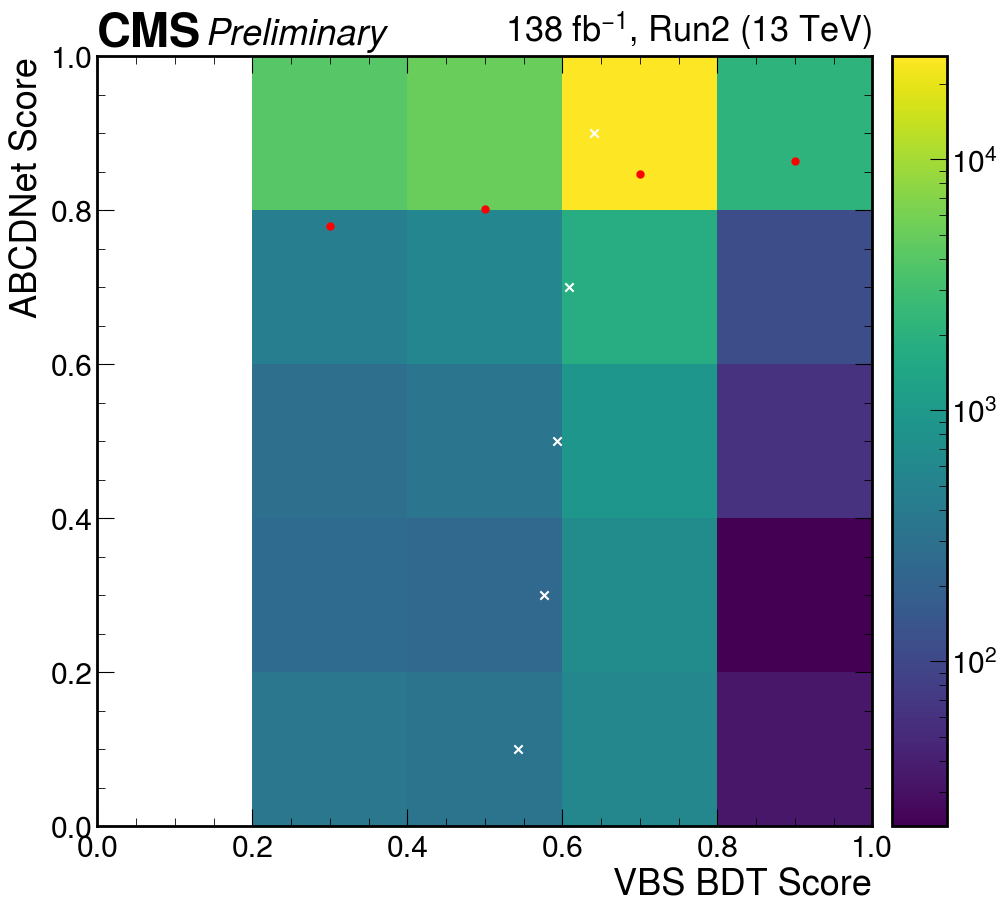

In [4]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root")
hist = df.Histo2D(("h", "2D histogram", 5, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

h = uproot.from_pyroot(hist).to_hist()

fig, ax = plt.subplots()
hep.hist2dplot(h, cbar=True, ax=ax, norm="log")
hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red")
ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="white", marker="x")


hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)

ax.set_xlabel("VBS BDT Score")
ax.set_ylabel("ABCDNet Score")

In [19]:
data = get_abcd("/data/userdata/aaarora/output/run2/sig.root")

In [32]:
data[["sample_year", "particlenet_h_weight_2016preVFP", "particlenet_w_weight_2016preVFP", "btagging_scale_factors_LF", "btagging_scale_factors_HF"]][(data.btagging_scale_factors_HF != 1)]

,sample_year,particlenet_h_weight_2016preVFP,particlenet_w_weight_2016preVFP,btagging_scale_factors_LF,btagging_scale_factors_HF
0,2017,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.8628087043762207 0.9264590740203857 0.80042...
0,2017,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.8628087043762207 0.9264590740203857 0.80042...
0,2017,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.8628087043762207 0.9264590740203857 0.80042...
32,2017,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.838512659072876 0.8570024371147156 0.820164...
32,2017,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.838512659072876 0.8570024371147156 0.820164...
...,...,...,...,...,...
84549,2018,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.9178869128227234 0.9436599016189575 0.89195...
84549,2018,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.9178869128227234 0.9436599016189575 0.89195...
84552,2018,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.9747257232666016 1.0432326793670654 0.90545...
84552,2018,[1.0 1.0 1.0],[1.0 1.0 1.0],[1.0 1.0 1.0],[0.9747257232666016 1.0432326793670654 0.90545...


# BKG

In [ ]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/bkg_MVA_abcdnet.root")

In [ ]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/bkg_MVA_abcdnet.root")
hist = df.Histo2D(("h", "2D histogram", 5, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

h = uproot.from_pyroot(hist).to_hist()

fig, ax = plt.subplots()
hep.hist2dplot(h, cbar=True, ax=ax, norm="log")
hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red")
ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="white", marker="x")

hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)

ax.set_xlabel("VBS BDT Score")
ax.set_ylabel("ABCDNet Score")